In [ ]:
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

# Visualization Principles Continued

In this section, we discuss principles of visualization for transformation, context, and smoothing.

## Principles of Transformation

The principles of data transformation give us useful ways to alter data for visualization in order to more effectively reveal trends. We most commonly apply data transformations to reveal patterns in skewed data and non-linear relationships between variables.

The plot below shows the distribution of ticket fares for each passenger aboard the Titanic. As you can see, the distribution is skewed right.

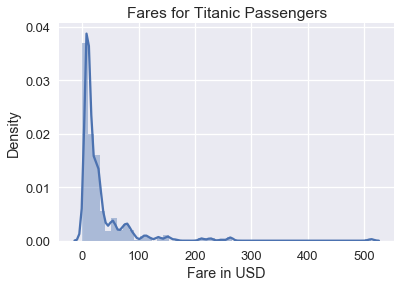

In [29]:
ti = sns.load_dataset('titanic')
sns.distplot(ti['fare'])
plt.title('Fares for Titanic Passengers')
plt.xlabel('Fare in USD')
plt.ylabel('Density');

Although this histogram shows the all the fares, it is difficult to see detailed patterns in the data since the fares are clumped on the left side of the histogram. To remedy this, we can take the natural log of the fares before plotting them:

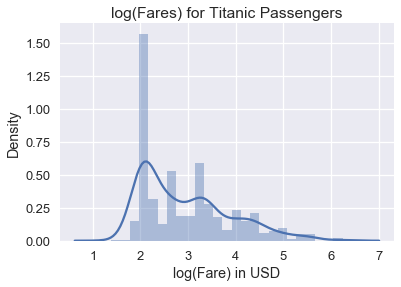

In [18]:
sns.distplot(np.log(ti.loc[ti['fare'] > 0, 'fare']), bins=25)
plt.title('log(Fares) for Titanic Passengers')
plt.xlabel('log(Fare) in USD')
plt.ylabel('Density');

We can see from the plot of the log data that the distribution of fares has a mode at roughly $ e^2 = \$7.40 $ and a smaller mode at roughly $ e^{3.4} = \$30.00 $. Why does plotting the natural log of the data help with skew? The logarithms of large numbers tend be close to the logarithms of small numbers:

| value | log(value) |
| ----- | ---------- |
| 1     | 0.00       |
| 10    | 2.30       |
| 50    | 3.91       |
| 100   | 4.60       |
| 500   | 6.21       |
| 1000  | 6.90       |

This means that taking the logarithm of right-tailed data will bring large values close to small values. This helps see patterns where the majority of the data lie.

In fact, the logarithm is considered the Swiss army knife of data tranformation—it also helps us see the nature of non-linear relationships between variables in the data. In 1619, Kepler recorded down the following set of data to discover his Third Law of Planetary Motion:

In [39]:
planets = pd.read_csv("data/planets.data", delim_whitespace=True,
                      comment="#", usecols=[0, 1, 2])
planets

,planet,mean_dist,period
0,Mercury,0.389,87.77
1,Venus,0.724,224.70
2,Earth,1.000,365.25
3,Mars,1.524,686.95
4,Jupiter,5.200,4332.62
5,Saturn,9.510,10759.20


If we plot the mean distance to the sun against the period of the orbit, we can see a relationship that doesn't quite look linear:

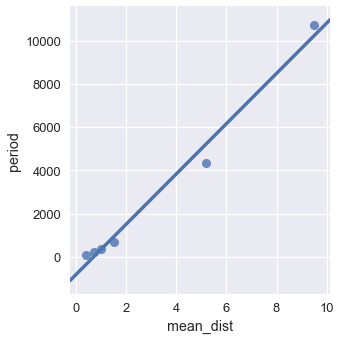

In [42]:
sns.lmplot(x='mean_dist', y='period', data=planets, ci=False)

However, if we take the natural log of both mean distance and period, we obtain the following plot:

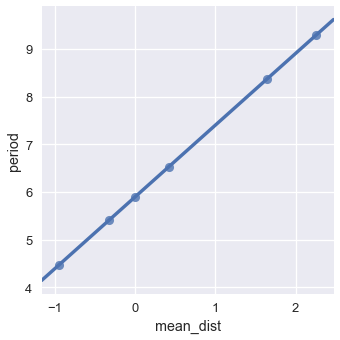

In [47]:
sns.lmplot(x='mean_dist', y='period',
           data=np.log(planets.iloc[:, [1, 2]]),
           ci=False);

We see a near-perfect linear relationship between the logged values of mean distance and period. What does this mean? Since we believe there's a linear relationship between the logged values, we can derive:

$$
\begin{aligned}
\log(period) &= m \log(dist) + b \\
period &= e^{m \log(dist) + b} & \text{Taking the exponent of both sides} \\
period &= e^b dist^m \\
period &= C \cdot dist^m
\end{aligned}
$$

We replaced $ e^b $ with $ C $ in the last step to represent $ e^b $ as a constant. The algebraic manipulation above shows that when two variables have a polynomial relationship, the log of the two variables has a linear relationship. In fact, we can find the degree of the polynomial by examining the slope of the line. In this case, the slope is 1.5 which gives us Kepler's third law: $ period \propto dist^{1.5} $.

By a similar derivation we can also show that if the relationship between the $ \log(y) $ and $ x $ is linear, the two variables have an exponential relationship: $ y = a^x $.

Thus, we can use the logarithm to reveal patterns in right-tailed data and common non-linear relationships between variables.

Other common data transformations include the Box-Cox transformation and polynomial transforms.

## Principles of Context

It is important to add as much relevant context as possible to any plot you plan to share more broadly. For example, the following plot shows its data clearly but provides little context to help understand what is being plotted.

![viz_principles_img/viz_538_before.png](viz_principles_img/viz_538_before.png)

To provide context, we add a title, caption, axes labels, units for the axes, and labels for the plotted lines.

![viz_principles_img/viz_538_after.png](viz_principles_img/viz_538_after.png)

([This blog post](https://www.dataquest.io/blog/making-538-plots/) explains how to make these modifications using `matplotlib`.)

In general, we provide context for a plot through:

- Plot title
- Axes labels
- Reference lines and markers for important values
- Labels for interesting points and unusual observations
- Captions that describe the data and its important features

## Principles of Smoothing

Smoothing allows us to more clearly visualize data when we have many data points. We've actually already seen an instance of smoothing: histograms are a type of smoothing for rugplots. This rugplot shows each age of the passengers in the Titanic.

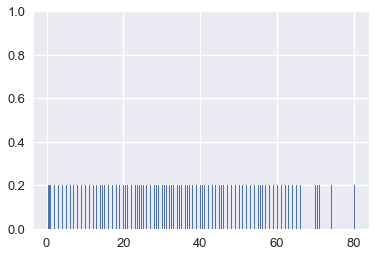

In [64]:
ages = ti['age'].dropna()
sns.rugplot(ages, height=0.2)

There are many marks that make it difficult to tell where the data lie. In addition, some of the points overlap, making it impossible to see how many points lie at 0. This issue is called *overplotting* and we generally avoid it whenever possible.

To reveal the distribution of the data, we can replace groups of marks with a bar that is taller when more points are in the group. Smoothing refers to this process of replacing sets of points with appropriate markers; we choose not to show every single point in the dataset in order to reveal broader trends.

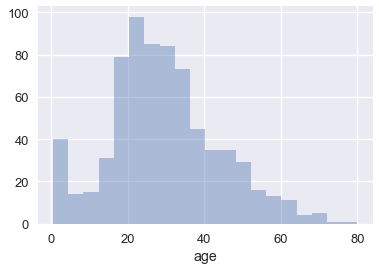

In [67]:
sns.distplot(ages, kde=False)

We've also seen that `seaborn` will plot a smooth curve over a histogram by default.

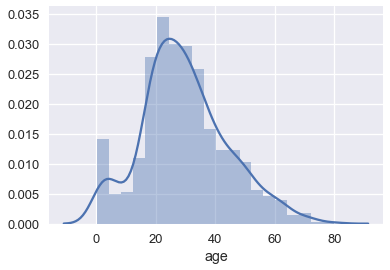

In [68]:
sns.distplot(ages)

This is another form of smoothing called *kernel density estimation* (KDE). Instead of grouping points together and plotting bars, KDE places a curve on each point and combines the individual curves to create a final estimation of the distribution. Consider the rugplot below that shows three points.

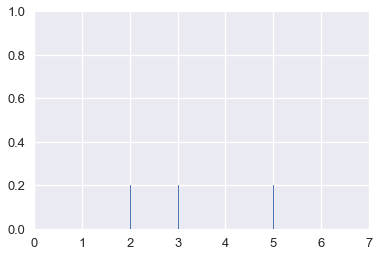

In [83]:
points = np.array([2, 3, 5])
sns.rugplot(points, height=0.2)
plt.xlim(0, 7);

To perform KDE, we place a Gaussian (normal) distribution on each point:

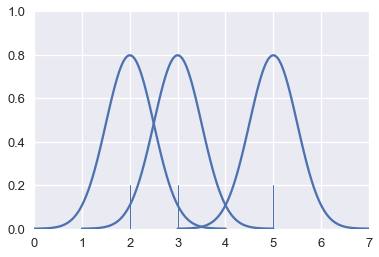

In [105]:
from scipy.stats import norm

def gaussians(points, scale=True, sd=0.5):
    x_vals = [np.linspace(point - 2, point + 2, 100) for point in points]
    y_vals = [norm.pdf(xs, loc=point, scale=sd) for xs, point in zip(x_vals, points)]
    if scale:
        y_vals = [ys / len(points) for ys in y_vals]
    return zip(x_vals, y_vals)

for xs, ys in gaussians(points, scale=False):
    plt.plot(xs, ys, c=sns.color_palette()[0])

sns.rugplot(points, height=0.2)
plt.xlim(0, 7)
plt.ylim(0, 1);

The area under each Gaussian curve is equal to 1. Since we will sum multiple curves together, we scale each curve so that when added together the area under all the curves is equal to 1.

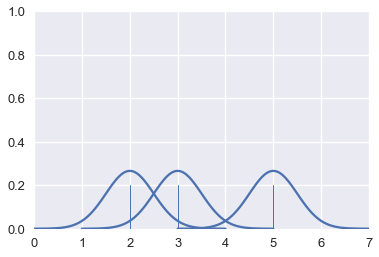

In [89]:
for xs, ys in gaussians(points):
    plt.plot(xs, ys, c=sns.color_palette()[0])

sns.rugplot(points, height=0.2)
plt.xlim(0, 7)
plt.ylim(0, 1);

Finally, we add the curves together to create a final smooth estimate for the distribution:

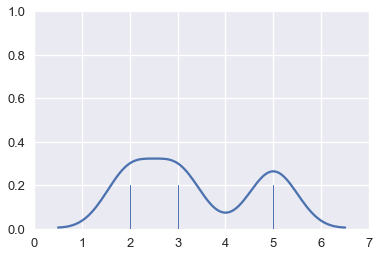

In [92]:
sns.rugplot(points, height=0.2)
sns.kdeplot(points, bw=0.5)
plt.xlim(0, 7)
plt.ylim(0, 1);

By following this procedure, we can use KDE to smooth many points.

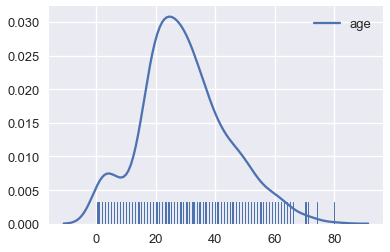

In [96]:
# Show the original unsmoothed points
sns.rugplot(ages, height=0.1)

# Show the smooth estimation of the distribution
sns.kdeplot(ages);

### Kernel Density Estimation Details

In the previous examples of KDE, we placed a miniature Gaussian curve on each point and added the Gaussians together. 

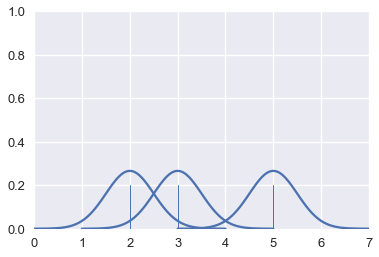

In [89]:
for xs, ys in gaussians(points):
    plt.plot(xs, ys, c=sns.color_palette()[0])

sns.rugplot(points, height=0.2)
plt.xlim(0, 7)
plt.ylim(0, 1);

We are free to adjust the width of the Gaussians. For example, we can make each Gaussian narrower. This is called decreasing the *bandwidth* of the kernel estimation.

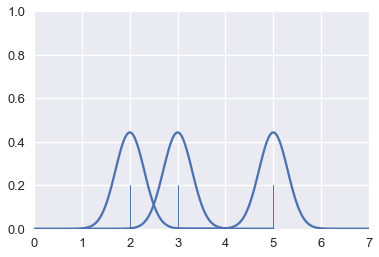

In [108]:
for xs, ys in gaussians(points, sd=0.3):
    plt.plot(xs, ys, c=sns.color_palette()[0])

sns.rugplot(points, height=0.2)
plt.xlim(0, 7)
plt.ylim(0, 1);

When we add these narrower Gaussians together, we create a more detailed final estimation.

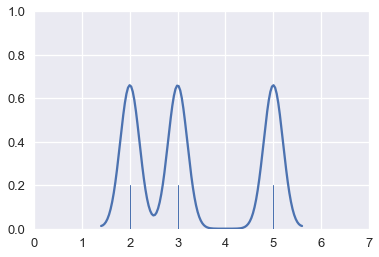

In [109]:
sns.rugplot(points, height=0.2)
sns.kdeplot(points, bw=0.2)
plt.xlim(0, 7)
plt.ylim(0, 1);

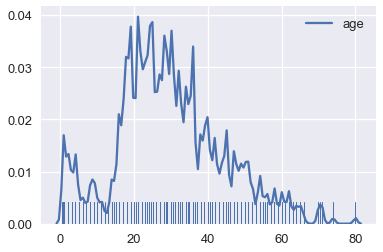

In [112]:
# Plot the KDE for Titanic passenger ages using a lower bandwidth
sns.rugplot(ages, height=0.1)
sns.kdeplot(ages, bw=0.5);

Just like adjusting bins for a histogram, we typically adjust the bandwidth until we believe the final plot shows the distribution without distracting the viewer with too much detail.

Although we have placed a Gaussian at each point so far, we can easily select other functions to estimate each point. This is called changing the *kernel* of the kernel density estimation. Previously, we've used a Gaussian kernel. Now, we'll use a triangular kernel which places a pair of stepwise sloped lines at each point:

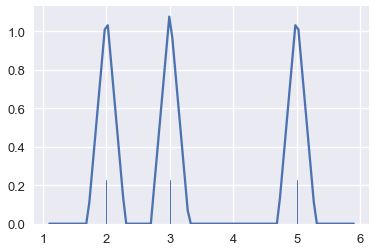

In [115]:
sns.rugplot(points, height=0.2)
sns.kdeplot(points, kernel='tri', bw=0.3)

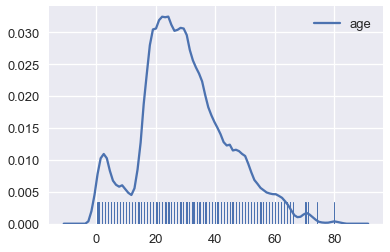

In [117]:
# Plot the KDE for Titanic passenger ages using a triangular kernel
sns.rugplot(ages, height=0.1)
sns.kdeplot(ages, kernel='tri');

Usually we'll use a Gaussian kernel unless we have a specific reason to use a different kernel.

### Smoothing a Scatter Plot

We can also smooth two-dimensional plots when we encounter the problem of overplotting.

The following example comes from a dataset released by the Cherry Blossom Run, an annual 10-mile run in Washington D.C. Each runner can report their age and their race time; we've plotted all the reported data points in the scatter plot below.

In [152]:
runners = pd.read_csv('data/cherryBlossomMen.csv').dropna()
runners

,year,place,age,time
0,1999,1,28.0,2819.0
1,1999,2,24.0,2821.0
2,1999,3,27.0,2823.0
...,...,...,...,...
70066,2012,7190,56.0,8840.0
70067,2012,7191,35.0,8850.0
70069,2012,7193,48.0,9059.0


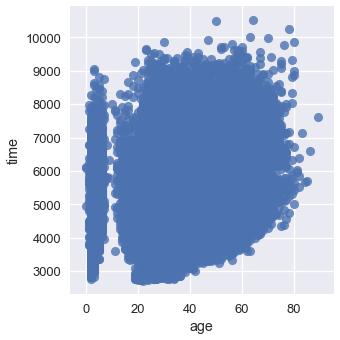

In [123]:
sns.lmplot(x='age', y='time', data=runners, fit_reg=False);

So many points lie on top of each other that it's difficult to see any trend at all!

We can smooth the scatter plot using kernel density estimation in two dimensions. When KDE is applied to a two-dimensional plot, we place a three-dimensional Gaussian at each point. In three dimensions, the Gaussian looks like a mountain pointing out of the page.

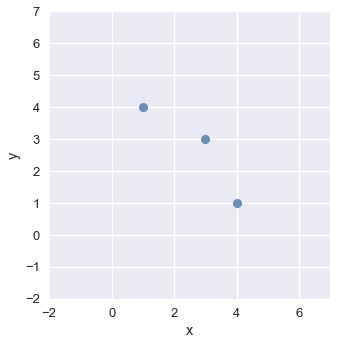

In [132]:
# Plot three points
two_d_points = pd.DataFrame({'x': [1, 3, 4], 'y': [4, 3, 1]})
sns.lmplot(x='x', y='y', data=two_d_points, fit_reg=False)
plt.xlim(-2, 7)
plt.ylim(-2, 7);

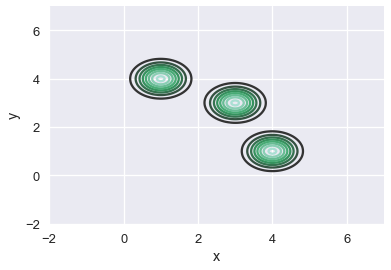

In [135]:
# Place a Gaussian at each point and use a contour plot to show each one
sns.kdeplot(two_d_points['x'], two_d_points['y'], bw=0.4)
plt.xlim(-2, 7)
plt.ylim(-2, 7);

Just like we've previously seen, we scale each Gaussian and add them together to obtain a final contour plot for the scatter plot.

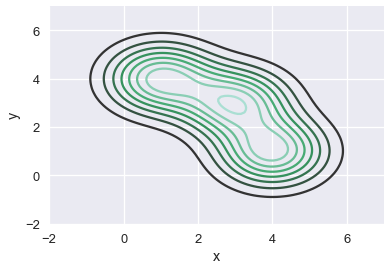

In [136]:
sns.kdeplot(two_d_points['x'], two_d_points['y'])
plt.xlim(-2, 7)
plt.ylim(-2, 7);

The resulting plot shows the downward sloping trend of the three points. Similarly, we can apply a KDE to smooth out the scatter plot of runner ages and times:

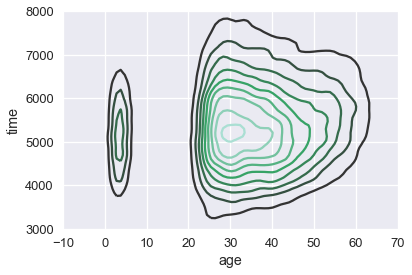

In [145]:
sns.kdeplot(runners['age'], runners['time'])
plt.xlim(-10, 70)
plt.ylim(3000, 8000);

We can see that most of our runners were between 25 and 50 years old, and that most runners took between 4000 and 7000 seconds (roughly between 1 and 2 hours) to finish the race.

We can see more clearly that there is a suspicious group of runners that are between zero and ten years old. We might want to double check that our data for those ages was recorded properly.

We can also see a slight upward trend in the time taken to finish the race as runner age increases.